In [1]:
import csv
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def mm_cross_simple(df,col_price,mm_short,mm_long):
    mm_short_name = str(mm_short) + 'MA'
    mm_long_name = str(mm_long) + 'MA'
    signal_mm = mm_short_name + mm_long_name
    df[mm_short_name] = df[col_price].rolling(window=mm_short).mean()
    df[mm_long_name] = df[col_price].rolling(window=mm_long).mean()
    df[signal_mm] = np.where(df[mm_short_name] > df[mm_long_name], 1,-1)
    return df

In [3]:
df = pd.read_csv('sample_data.csv', delimiter = ',')   #price data

In [4]:
def return_cum_strat_last_el(df, mm_short, mm_long, mm_short2, mm_long2, plot=False):
    
    #col title in the df
    signal_ma = str(mm_short) + 'MA' + str(mm_long) + 'MA'
    signal_ma1 = str(mm_short2) + 'MA' + str(mm_long2) + 'MA'
    tc = .002      #transaction cost
    
    df['price'] = df['price'].astype(float)
    df['date'] = df['time']/1000                      #binance time is in milliseconds-> transform in seconds
    df['date'] = pd.to_datetime(df['date'], unit='s') #format binance date in readable date 

    #signal calcul
    df = mm_cross_simple(df,'price', mm_short, mm_long)     #add in df above: short_ma, long_ma, signal_mm
    df = mm_cross_simple(df,'price', mm_short2, mm_long2)   #add in df above: short_ma, long_ma, signal_mm
    
    df['signal'] = (df[signal_ma] + df[signal_ma1])/2                          #create df signal: sell if -1 and buy if +1
    df['signal_chg'] = np.where(df['signal'] != df['signal'].shift(1), 1,0)    #count signal change, then number of trades
    df['tc'] = df['signal_chg'] * tc                                           #calc transactions cost
    df['tc'] = df['tc'].cumsum()
    
    #return calculations
    df['return'] = (df['price'] / df['price'].shift(1))-1                      #calc returns per minute for the series
    df['cum_return'] = (1 + df['return']).cumprod() - 1                        #calc cumulated returns for the series
    df['strat_ret'] = df['return'] * df ['signal']                             #calc strategy returns per minute for the series
    df['cum_strat_ret'] = (1 + df['strat_ret']).cumprod() - 1                  #calc strategy cumulated returns
    df['cum_strat_ret_tc'] = df['cum_strat_ret'] - df['tc']                    #remove transactions costs

    if plot:
        df.plot(x = 'date', y='cum_strat_ret_tc')                                  #graph the strategy returns 
    
    return df['cum_strat_ret_tc'].iloc[-1]                     # last element of Series df[..]

9.34854660703866

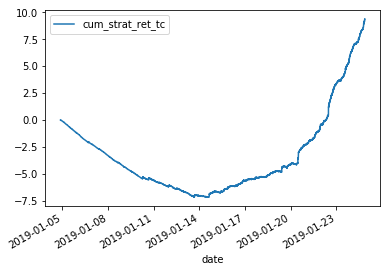

In [5]:
return_cum_strat_last_el(df, 2, 3, 3, 4, plot=True)

In [ ]:
''' 
Conditions:
short < long, short2 < long2

5 <= short <= 100
50 <= short2 <= 200
10 <= long <= 200
100 <= long2 <= 500
'''

# arguments
print_progress=False 
write_progress=True
print_result=False

# initialise data structures and helpers
a_dict = {}
short_values = []
long_values = []
cum_strat_values = []
try:
    os.remove('running_progress.csv')
except:
    pass

# run through combinations
for short in range(2,101, 5):
    for long in range(short+1 ,201, 5):
          for short2 in range(long ,201, 10):
                for long2 in range(short2+1 ,501, 20):
                    last_cum_strat_value = return_cum_strat_last_el(df, short, long, short2, long2)
                    a_dict[last_cum_strat_value] = (short, long, short2, long2)

                    if print_progress:
                        print(
                            'last_el_df_cum_strat:{},'.format(last_cum_strat_value) +
                            ' short:{},'.format(short) +
                            ' long:{},'.format(long) +
                            ' short2:{},'.format(short2) +
                            ' long2:{},'.format(long2))
                    if write_progress:
                        with open('pascal_running_progress.csv', 'a') as f:
                            writer = csv.writer(f)
                            writer.writerow([last_cum_strat_value, short, long, short2, long2])
if print_result:
    maximum = max(a_dict)
    print(
        'The highest cum_strat_value is {}, with'.format(maximum) +
        ' mm_short={},'.format(a_dict[maximum][0]) +
        ' mm_long={},'.format(a_dict[maximum][1]) +
        ' mm_short2={},'.format(a_dict[maximum][2]) +
        ' mm_long2={}'.format(a_dict[maximum][3]))

In [ ]:
maximum = max(a_dict)
print(
    'The highest cum_strat_value is {}, with'.format(maximum) +
    ' mm_short={},'.format(a_dict[maximum][0]) +
    ' mm_long={},'.format(a_dict[maximum][1]) +
    ' mm_short2={},'.format(a_dict[maximum][2]) +
    ' mm_long2={}'.format(a_dict[maximum][3]))

In [ ]:
pd.DataFrame.from_dict(a_dict).transpose().plot(kind='bar', figsize=(100,20), grid=1)